In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import f1_score,recall_score,precision_score

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn_pandas import DataFrameMapper
from joblib import dump, load


In [ ]:

con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 


def partition(x):
    if x < 3:
        return 0
    return 1


actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [ ]:
display['COUNT(*)'].sum()

393063

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(37415, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.5375

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(37415, 10)


1    31324
0     6091
Name: Score, dtype: int64

In [ ]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 37415/37415 [00:07<00:00, 5053.69it/s]


'perfect'

In [ ]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(26190,) (11225,) (26190,) (11225,)


In [ ]:
avg_w2v_trained_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_100000'
avg_w2v_test_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_100000'

w2v_tf_idf_trained_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_100000'
w2v_tf_idf_test_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_100000'

In [ ]:
# Common Methods

alpha_values = (1e-4, 1e-3,1e-2,0.05,1e-1,0.5, 1e0,1e1,1e2,1e3)
gamma_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]

def finding_best_alpha(X_tr,y_tr,which_method,whichAlgo, penalty):

    if whichAlgo == 'SGDClassifier' :
        # instantiate a SGDClassifier
        if penalty == 'l1':
            clf = SGDClassifier(loss='hinge', class_weight='balanced',n_jobs=-1, penalty='l1', random_state=1)
        else:
            clf = SGDClassifier(loss='hinge', class_weight='balanced',n_jobs=-1, penalty='l2', random_state=1)
        param_grid=dict(alpha=alpha_values)
    else:
        # instantiate a SVC
        clf = SVC(kernel='rbf', class_weight='balanced')
        param_grid=dict(gamma=gamma_values, C=gamma_values)
        
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=10)
    
    if which_method == 'gridsearch':
    
        # instantiate the grid for training data
        trained = GridSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10 )
    else:
        # instantiate the grid for training data
        trained = RandomizedSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10, n_iter = 15)
        
    # fit with traing data
    trained.fit(X_tr, y_tr)
    
    return trained


# plot a graph which show difference between validation error and training error
def plotAccuracyGraph(training_grid):
    alpha_range = [i for i in alpha_values]
    accuracy = [i for i in training_grid.cv_results_['mean_train_score']]
    accuracy_test = [i for i in training_grid.cv_results_['mean_test_score']]
    plt.semilogx(alpha_range, accuracy,'r',label='train_accuracy')
    plt.semilogx(alpha_range, accuracy_test,'b',label='validation_accuracy')
    plt.title('Accuracy plot')
    plt.xlabel('Alpha') 
    plt.ylabel('Accuracy')
    plt.grid('on')
    plt.legend()
    plt.show()

# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# plot AUC curve
def plotAUC_ROC(nb_optimal,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = nb_optimal.predict_proba(X_test)
    train_probs = nb_optimal.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


## [4.3] TF-IDF

In [ ]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10,  max_features = 500) #in scikit-learn

# train data
X_train_tfidf = tf_idf_vect.fit_transform(X_train)

# test data
x_test_tfidf = tf_idf_vect.transform(x_test)

print('X_train_tfidf', X_train_tfidf.shape)
print('==='*10)
print('x_test_tfidf', x_test_tfidf.shape)

(26190,) (11225,) (26190,) (11225,)
X_train_tfidf (26190, 500)
x_test_tfidf (11225, 500)


### Hyper parameter tunign using GridSearch

In [ ]:
tfidf_hyperparam_path = '/home/pranay/Amazon Assignments/SVM RBF/tfidf_hyperparam_tune'
exists = os.path.isfile(tfidf_hyperparam_path)

if exists:
    print('yes exists')
    tfidf_train = load(tfidf_hyperparam_path)
else:
    print('not exists')
    tfidf_train = finding_best_alpha (X_train_tfidf,y_train, 'gridsearch','RBF','l2')
    dump(tfidf_train,tfidf_hyperparam_path)


# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

gamma_val = tfidf_train.best_params_.get("gamma", "")
C_val = tfidf_train.best_params_.get("C", "")
print('\n'+color.RED+'Optimal best gamma is : '+color.END+color.BOLD+str(gamma_val)+color.END)
print('\n'+color.RED+'Optimal best C value is : '+color.END+color.BOLD+str(C_val)+color.END)

yes exists
=======Training========
0.9021741347522226
{'C': 1, 'gamma': 1}
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimal best gamma is : 1

Optimal best C value is : 1



Optimal best gamma is : 0.01

Optimal best C value is : 1

Confusion Matrix for Train data


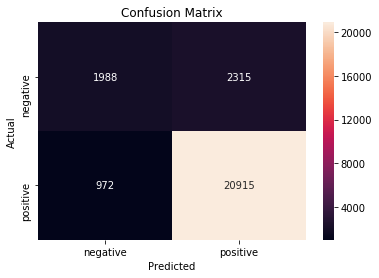


Confusion Matrix for Test data


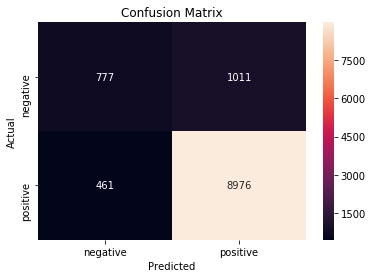

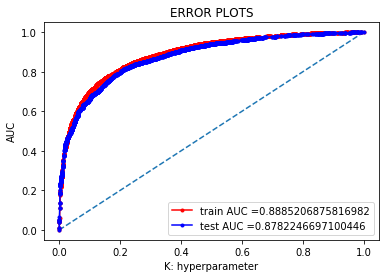


AUC (Train): 0.8885206875816982

AUC (Test): 0.8782246697100446

F1 SCORE (Train) : 0.9271449786111665

F1 SCORE (Test) : 0.9242174629324547

RECALL (Train): 0.9555900763010006

RECALL (Test): 0.9511497297870086

PRECISION  (Train) : 0.9003443822643133

PRECISION  (Test) : 0.8987683989185942


In [ ]:
optimal_model = SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=gamma_val,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib.fit(X_train_tfidf,y_train)

# predict the response
test_pred = model_calib.predict(x_test_tfidf)
train_pred = model_calib.predict(X_train_tfidf)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)